#### 1. 生成模拟数据集。

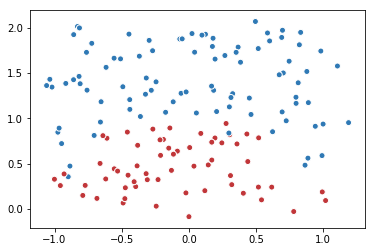

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1:
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)
        
data = np.hstack(data).reshape(-1,2)
label = np.hstack(label).reshape(-1, 1)
plt.scatter(data[:,0], data[:,1], c=np.squeeze(label),cmap="RdBu", vmin=-0.2, vmax=1.2, edgecolor="white")
plt.show()

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。

In [9]:
def get_weight(shape, lambda1):
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var

#### 3. 定义神经网络。

In [10]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)

# 每层节点的个数
layer_dimension = [2,10,5,3,1]

n_layers = len(layer_dimension)

cur_layer = x
in_dimension = layer_dimension[0]

# 循环生成网络结构
for i in range(1, n_layers):
    out_dimension = layer_dimension[i]
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y= cur_layer

# 损失函数的定义。
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size
tf.add_to_collection('losses', mse_loss)
loss = tf.add_n(tf.get_collection('losses'))

#### 4. 训练不带正则项的损失函数mse_loss。

After 0 steps, mse_loss: 1.641536
After 2000 steps, mse_loss: 0.059334
After 4000 steps, mse_loss: 0.036992
After 6000 steps, mse_loss: 0.031669
After 8000 steps, mse_loss: 0.030221
After 10000 steps, mse_loss: 0.028920
After 12000 steps, mse_loss: 0.027556
After 14000 steps, mse_loss: 0.027143
After 16000 steps, mse_loss: 0.025330
After 18000 steps, mse_loss: 0.025032
After 20000 steps, mse_loss: 0.024471
After 22000 steps, mse_loss: 0.024243
After 24000 steps, mse_loss: 0.024079
After 26000 steps, mse_loss: 0.023942
After 28000 steps, mse_loss: 0.023859
After 30000 steps, mse_loss: 0.023711
After 32000 steps, mse_loss: 0.024139
After 34000 steps, mse_loss: 0.023529
After 36000 steps, mse_loss: 0.023315
After 38000 steps, mse_loss: 0.023857


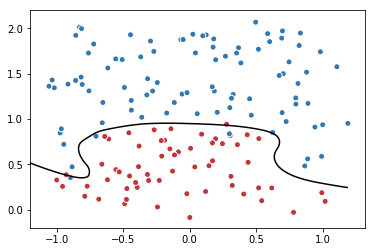

In [12]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, mse_loss: %f" % (i,sess.run(mse_loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1.2:1.2:.01, -0.2:2.2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=np.squeeze(label),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

#### 5. 训练带正则项的损失函数loss。

After 0 steps, loss: 1.944676
After 2000 steps, loss: 0.145429
After 4000 steps, loss: 0.094901
After 6000 steps, loss: 0.068660
After 8000 steps, loss: 0.057940
After 10000 steps, loss: 0.056309
After 12000 steps, loss: 0.056097
After 14000 steps, loss: 0.055916
After 16000 steps, loss: 0.055740
After 18000 steps, loss: 0.055712
After 20000 steps, loss: 0.055706
After 22000 steps, loss: 0.055704
After 24000 steps, loss: 0.055702
After 26000 steps, loss: 0.055701
After 28000 steps, loss: 0.055701
After 30000 steps, loss: 0.055700
After 32000 steps, loss: 0.055701
After 34000 steps, loss: 0.055700
After 36000 steps, loss: 0.055700
After 38000 steps, loss: 0.055699


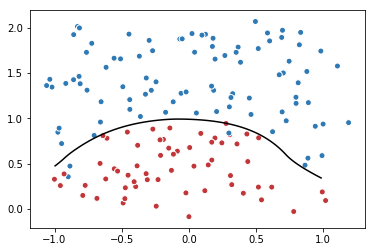

In [13]:
# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=np.squeeze(label),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()